In [344]:
import pandas as pd
import numpy as np
import os
import geopandas as gpd
import seaborn as sns
import networkx as nx
import matplotlib.pyplot as plt
from math import radians
sns.set()

In [2]:
joinedSGGeo =pd.read_parquet("finalJoined.parquet")
joinedSGGeo["Date"]=pd.to_datetime(joinedSGGeo.pingtimestamp,unit='s')

# Sythesis Data

In [3]:
aggregatedData=joinedSGGeo.groupby(["REGION_N","id","trj_id"]).agg({"pingtimestamp":["min","max","mean"]})
aggregatedData.columns = ["time_min","time_max","time_mean"]
aggregatedData=aggregatedData.reset_index()

In [4]:
aggregatedData["Rank"]=aggregatedData.groupby("trj_id")["time_min"].rank(method="first")

In [5]:
lastDestinationData= aggregatedData.sort_values(["trj_id","Rank"]).drop_duplicates("trj_id",keep="last")[["REGION_N","id","trj_id","Rank"]]

In [6]:
replicatedData=pd.DataFrame()
for num in [5,10,15,20,25,30,35]:
    print(num)
    lastDestinationData["value"]=np.random.randint(2,num,size=(28000,1))
    lastDestinationData["NewRank"]=lastDestinationData["Rank"]-lastDestinationData["value"]
    if replicatedData.empty:
        replicatedData = lastDestinationData[lastDestinationData["Rank"]>20+num].copy()
    else:
        replicatedData = replicatedData.append(lastDestinationData[lastDestinationData["Rank"]>20+num].copy())
        

5
10
15
20
25
30
35


In [7]:
for num in range(2):
    print(num)
    lastDestinationData["value"]=np.random.randint(5,11,size=(28000,1))
    lastDestinationData["NewRank"]=lastDestinationData["Rank"]-lastDestinationData["value"]
    if replicatedData.empty:
        replicatedData = lastDestinationData.copy()
    else:
        replicatedData = replicatedData.append(lastDestinationData.copy())

0
1


In [8]:
for num in range(2):
    print(num)
    lastDestinationData["value"]=np.random.randint(2,11,size=(28000,1))
    lastDestinationData["NewRank"]=lastDestinationData["Rank"]-lastDestinationData["value"]
    if replicatedData.empty:
        replicatedData = lastDestinationData[lastDestinationData["Rank"]>60].copy()
    else:
        replicatedData = replicatedData.append(lastDestinationData[lastDestinationData["Rank"]>60].copy())

0
1


/root/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1706: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


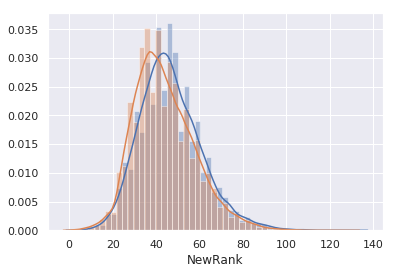

In [9]:
sns.distplot(lastDestinationData["Rank"])
sns.distplot(replicatedData[replicatedData["NewRank"]>0]["NewRank"])

In [10]:
finalReplicatedData=replicatedData[["trj_id","NewRank"]].drop_duplicates().rename({"NewRank":"Rank"},axis=1)\
        .append(lastDestinationData[["trj_id","Rank"]].drop_duplicates())

In [11]:
finalReplicatedData=finalReplicatedData.sort_values(["trj_id","Rank"]).reset_index(drop=True).reset_index()

In [12]:
finalReplicatedData[finalReplicatedData["trj_id"]=="10"]

,index,trj_id,Rank
0,0,10,17.0
1,1,10,21.0
2,2,10,23.0
3,3,10,26.0


In [13]:
finalReplicatedData.columns=['newTrj_id', 'trj_id', 'Rank']

# Prepare the Synthesis Training Data

In [14]:
finalReplicatedData.shape

(180453, 3)

In [15]:
destinationReplicatedData=finalReplicatedData.merge(aggregatedData, on=["trj_id","Rank"])

In [16]:
destinationReplicatedData["Key"]=1

In [17]:
pickupData= aggregatedData.sort_values(["trj_id","Rank"]).drop_duplicates("trj_id",keep="first")#[["REGION_N","id","trj_id","Rank"]]

In [18]:
pickupData["Key"]=pickupData["Rank"]

In [19]:
finalTrainingData=pickupData.merge(destinationReplicatedData,on=["Key","trj_id"], suffixes=('_pickup', '_destination'))

In [20]:
finalTrainingData["answer"]=finalTrainingData["time_max_destination"]-finalTrainingData["time_min_pickup"]

In [21]:
finalTrainingData[finalTrainingData["trj_id"]=="9984"]

,REGION_N_pickup,id_pickup,trj_id,time_min_pickup,time_max_pickup,time_mean_pickup,Rank_pickup,Key,newTrj_id,Rank_destination,REGION_N_destination,id_destination,time_min_destination,time_max_destination,time_mean_destination,answer
180424,WEST REGION,2131,9984,1555724314,1555724347,1.555724e+09,1.0,1.0,180446,33.0,CENTRAL REGION,3822,1555725068,1555725071,1.555725e+09,757
180425,WEST REGION,2131,9984,1555724314,1555724347,1.555724e+09,1.0,1.0,180447,37.0,CENTRAL REGION,3893,1555725208,1555725281,1.555725e+09,967
180426,WEST REGION,2131,9984,1555724314,1555724347,1.555724e+09,1.0,1.0,180448,41.0,CENTRAL REGION,3966,1555725449,1555725507,1.555725e+09,1193
180427,WEST REGION,2131,9984,1555724314,1555724347,1.555724e+09,1.0,1.0,180449,43.0,CENTRAL REGION,3967,1555725532,1555725551,1.555726e+09,1237
180428,WEST REGION,2131,9984,1555724314,1555724347,1.555724e+09,1.0,1.0,180450,47.0,CENTRAL REGION,4039,1555725724,1555725785,1.555726e+09,1471
180429,WEST REGION,2131,9984,1555724314,1555724347,1.555724e+09,1.0,1.0,180451,48.0,CENTRAL REGION,4110,1555725786,1555725828,1.555726e+09,1514
180430,WEST REGION,2131,9984,1555724314,1555724347,1.555724e+09,1.0,1.0,180452,50.0,CENTRAL REGION,4179,1555725843,1555725862,1.555726e+09,1548


# Prepare the Actual Training Data

In [22]:
testingData=pd.read_csv("TripAnswerSheet.csv")

answer=joinedSGGeo.groupby("trj_id").agg({"pingtimestamp":["min","max"],"Date":["min","max"]})
answer.columns=[item[0]+"_"+item[1] for item in answer.columns]
answer["answer1"]=answer.pingtimestamp_max-answer.pingtimestamp_min
answer["answer2"]=answer.Date_max-answer.Date_min
answer["answer2"]=answer["answer2"].apply(lambda x: x.seconds)
answer=answer.reset_index()

testingData.trj_id=testingData.trj_id.astype(int)
answer.trj_id=answer.trj_id.astype(int)

finalAnswer=testingData.merge(answer,on="trj_id")

In [23]:
data=pd.read_csv("TripNetworkData.csv")

In [24]:
data["popularity+time"]=data["mean"]* data["path_popularity"]

/root/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1706: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


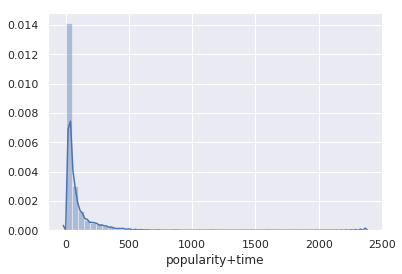

In [25]:
sns.distplot(data["popularity+time"])

/root/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1706: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


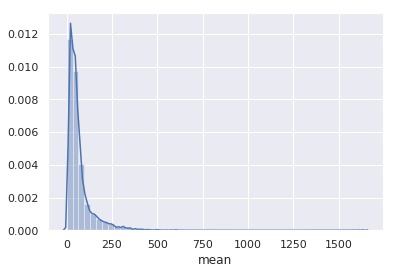

In [26]:
sns.distplot(data["mean"])

In [27]:
hexagon = gpd.read_file("hexagon500.geojson")

In [28]:
G=nx.from_pandas_edgelist(data[data.Distance<1.2], "pickup_id", 'destination_id',
                          edge_attr=[ 'mean', 'path_popularity', 'popularity+time',"trip_count","path_popularity"],create_using=nx.DiGraph())

In [984]:
from joblib import dump

In [985]:
dump(G,"finalNetwork.pickle")

['finalNetwork.pickle']

In [29]:
nx.dijkstra_path_length(G,2681,4025, weight="popularity+time")

156.47644922630786

In [30]:
tripDataRemoveDuplication=joinedSGGeo.sort_values("pingtimestamp").drop_duplicates(["trj_id","id","REGION_N","Date"],keep="first")
mergedPolygon=tripDataRemoveDuplication[["trj_id","id","REGION_N","Date"]].merge(hexagon[["id","REGION_N","geometry"]],on=["id","REGION_N"])

In [31]:
tripID="14833"
inPath=2538
endPath=4934
shortestPath=nx.dijkstra_path(G,inPath,endPath, weight="popularity+time")
shortestPath2=nx.dijkstra_path(G,inPath,endPath, weight="mean")
total_time=0
for index in range(len(shortestPath)-1):
    a=shortestPath[index]
    b=shortestPath[index+1]
    total_time+=G[a][b]['mean']
   
print(total_time,nx.dijkstra_path_length(G,inPath,endPath, weight="mean"))
actual=mergedPolygon[mergedPolygon.trj_id==tripID][["id","geometry"]].copy()
actual["Type"]="actual"
a=hexagon[hexagon.id.isin(shortestPath)][["id","geometry"]].copy()
a["Type"]="popularity+time"
b=hexagon[hexagon.id.isin(shortestPath2)][["id","geometry"]].copy()
b["Type"]="time"

1027.0543543440222 680.0390200481664


In [32]:
type(actual)

pandas.core.frame.DataFrame

In [33]:
a.append(actual,sort=False).append(b,sort=False).to_file('trip'+tripID+'Shape.geojson', driver='GeoJSON')

In [34]:
finalAnswer.head(1000)

,picku_Region,pickup_id,trj_id,destination_Region,destination_id,pingtimestamp_min,pingtimestamp_max,Date_min,Date_max,answer1,answer2
0,CENTRAL REGION,3467,10,CENTRAL REGION,4295,1554809147,1554810296,2019-04-09 11:25:47,2019-04-09 11:44:56,1149,1149
1,EAST REGION,5978,100,CENTRAL REGION,4230,1555382655,1555383648,2019-04-16 02:44:15,2019-04-16 03:00:48,993,993
2,NORTH REGION,3228,1000,NORTH-EAST REGION,4573,1554943773,1554944629,2019-04-11 00:49:33,2019-04-11 01:03:49,856,856
3,NORTH-EAST REGION,4082,10001,WEST REGION,2552,1555502175,1555503425,2019-04-17 11:56:15,2019-04-17 12:17:05,1250,1250
4,NORTH REGION,2878,10004,NORTH-EAST REGION,5407,1554779556,1554780407,2019-04-09 03:12:36,2019-04-09 03:26:47,851,851
...,...,...,...,...,...,...,...,...,...,...,...
995,WEST REGION,2538,14833,CENTRAL REGION,4934,1555449097,1555450057,2019-04-16 21:11:37,2019-04-16 21:27:37,960,960
996,CENTRAL REGION,4158,14834,NORTH REGION,3228,1555225720,1555226590,2019-04-14 07:08:40,2019-04-14 07:23:10,870,870
997,WEST REGION,2474,14836,CENTRAL REGION,4722,1554965020,1554966151,2019-04-11 06:43:40,2019-04-11 07:02:31,1131,1131
998,NORTH REGION,2674,14837,NORTH-EAST REGION,5205,1555562329,1555563790,2019-04-18 04:38:49,2019-04-18 05:03:10,1461,1461


In [35]:
def getbaseLineETA(df,columns=["pickup_id","destination_id","trj_id"]):
    predictedTime=[]
    predictedPath=[]
    predictedPath2=[]
    predictedTime2=[]
    for item in df[columns].values.tolist():
        print(item[2])
        if G.has_node(item[0]) and G.has_node(item[1]):
            if nx.has_path(G,item[0],item[1]):
                shortestPath=nx.dijkstra_path(G,item[0],item[1], weight="popularity+time")
                shortestPath2=nx.dijkstra_path(G,item[0],item[1], weight="mean")
                total_time=0
                for index in range(len(shortestPath)-1):
                    a=shortestPath[index]
                    b=shortestPath[index+1]
                    total_time+=G[a][b]['mean']
                predictedTime.append(total_time)
                predictedPath.append(shortestPath)
                predictedTime2.append(nx.dijkstra_path_length(G,item[0],item[1], weight="mean"))
                predictedPath2.append(shortestPath2)
            else:
                predictedTime.append("")
                predictedPath.append([])
                predictedTime2.append("")
                predictedPath2.append([])
        else:
            predictedTime.append("")
            predictedPath.append([])
            predictedTime2.append("")
            predictedPath2.append([])
    return predictedTime,predictedPath,predictedTime2,predictedPath2

In [37]:
predictedTime,predictedPath,predictedTime2,predictedPath2 =getbaseLineETA(finalAnswer)

10
100
1000
10001
10004
10005
1001
10010
10011
10013
10018
1002
10027
1003
10031
10037
10038
1004
10042
1005
10050
1006
10063
10064
10067
1007
10077
1008
10087
10088
1009
101
1010
10103
1011
10113
1012
10120
1013
10133
1014
1015
10153
10154
1016
10161
10164
1017
10170
1018
1019
10195
10199
102
1020
1021
1022
10220
1023
10232
10235
10238
1024
10245
1025
10254
10256
1026
10263
10266
1027
10273
10278
1028
10281
10284
10285
1029
10291
10292
10297
103
1030
1031
10318
10319
1032
1033
10330
10337
1034
10346
1035
10356
10359
1036
10360
10363
1037
10371
10377
1038
10386
1039
10394
104
1040
10401
10402
10405
1041
10411
10418
1042
10420
10429
1043
1044
10445
1045
10452
10454
10459
1046
10462
10463
1047
1048
10485
10486
10488
1049
105
1050
10500
10501
10508
10509
1051
10510
1052
10520
10524
10526
1053
1054
10545
1055
10551
1056
10560
10564
10567
1057
10570
10576
10577
1058
10582
10584
10587
10588
1059
10597
106
1060
10603
10607
1061
10616
10618
1062
10626
10627
1063
1064
10647
1065
10654
1066
1067

17323
17332
17340
17356
17357
1736
17361
17362
17364
17368
1737
17376
17380
17381
17384
17393
17396
174
17401
17406
17419
17422
17443
17447
17459
17480
175
17503
17504
17506
17509
17510
17528
17536
17546
17547
17551
17556
17558
1756
17560
17563
17570
17572
17582
1759
17592
17593
17598
17599
176
17601
1761
17615
17627
17638
17653
17654
17667
1768
17681
17697
177
17721
17723
17726
17732
17734
17737
17738
17743
17750
17753
17763
17768
17778
17788
17794
17796
178
17805
17814
17826
17836
17853
17857
17861
17871
17875
17897
17899
179
17902
17908
17917
17924
17935
17951
17955
17963
17965
17967
1798
17994
17996
180
18002
18011
18013
18014
18018
18029
18033
18034
18036
18058
18066
18076
18079
18081
18091
18094
18095
181
18103
18116
1812
18123
18137
18140
18144
18148
18155
18156
18178
1818
18181
18183
18192
182
18205
18208
18228
18230
18231
18232
18235
18239
18242
18248
18259
18261
18262
18267
18274
18280
18281
18284
18285
18289
18292
183
18305
18307
1831
18310
18312
18315
18322
18329
1833
18331

24334
24341
24344
24347
24348
24350
24352
24353
24355
24357
24363
24364
24367
24370
24371
24374
24380
24386
24391
24397
24398
244
24401
24403
24404
24405
24407
24408
24409
2441
24412
24413
24414
24419
24421
24422
24425
24445
24446
24449
24454
24457
24467
24468
24469
2447
24474
24475
24479
24481
24482
24485
24496
245
2450
24506
24508
24511
24516
24517
24522
24523
24525
24528
24530
24534
24540
24541
24547
24551
24553
24554
24555
24557
24560
24562
24564
24565
24566
24573
24575
2458
24581
24583
24584
24586
24587
24589
2459
24592
24593
24594
24597
246
24605
24606
24609
2461
24625
24626
24632
24637
24640
24651
24655
24659
24671
24672
24675
24678
24679
24681
24685
24687
2469
24691
24692
24695
24699
247
2470
24700
24705
2471
24713
24715
24717
24718
2472
24729
24732
24737
24739
24741
24744
24745
24746
24747
24749
24750
24751
24753
24758
24759
24761
24763
24764
24767
24771
24778
24779
24780
24787
24788
24789
24790
24792
24797
248
24803
24805
24806
24809
24812
24814
24820
24828
24833
24846
24847


28927
28929
28931
28933
28934
28939
28942
28945
28946
2895
28952
28953
28962
28964
28977
28985
28986
28990
28991
28992
28998
29
290
29005
29007
29014
29024
29026
29029
29031
29034
29036
29044
29045
29052
29054
29055
29056
29058
29059
29061
29062
29063
29064
29065
29066
29068
2907
29072
29073
29074
2908
29081
29084
29086
29088
29091
29092
29097
29098
29099
291
2910
29100
29106
29107
29109
29115
29116
29120
29125
29126
29128
29131
29132
29133
29135
29137
29143
29146
29149
29159
29163
29176
29180
29181
29185
29189
29197
29198
29199
292
29200
29201
29203
29204
29205
29206
29207
29208
29210
29211
29212
29213
29216
2922
29225
29227
29230
29235
29237
29240
29243
29245
29247
29248
29252
29254
29256
29260
29261
29263
29267
29273
29274
29275
29277
29278
29279
29280
29283
29286
29288
29292
29293
29294
29296
29298
293
29302
29303
29304
29307
29309
2931
29315
29320
29321
29325
29332
29333
29334
29335
29336
29337
29339
29343
29350
29351
29353
29354
29360
29363
29365
29370
29386
29387
29389
29392
293

33576
33577
33579
33580
33581
33585
33586
3359
33593
33597
336
33600
33604
33606
33608
33610
33611
33612
33614
33616
33617
33619
33620
33621
33624
33632
33640
33641
33642
33648
33650
33666
33667
33671
33674
33678
3368
33683
33687
33694
33695
33698
337
3370
33706
33707
33709
33710
33711
33714
33715
33716
3372
33720
33724
33725
33727
33731
33738
33739
33742
33744
3375
33751
33756
33757
3376
33764
33767
33768
3377
33770
33771
33772
33776
33779
33781
33788
33789
33790
33791
33792
33798
33799
338
33802
33805
33806
33810
33813
33815
33816
3382
33820
33825
33826
33828
33829
33830
33835
33838
33839
33844
33846
33859
33863
33864
33866
33869
33873
33877
33882
33883
33884
33885
33886
33890
33891
33892
33896
33897
339
3390
33900
33901
33902
33908
33912
33917
33919
33929
33939
33940
33941
33942
33945
33947
3395
33954
33961
33968
33973
33977
33978
33979
3398
33981
33992
33994
34
340
34001
34003
34007
34010
34011
34013
34014
34017
3402
34021
34026
34028
34033
34039
34040
34041
34046
34048
34051
34053

38383
38384
38387
38388
38392
38395
38396
384
3840
38403
38404
38406
38407
38409
38412
38415
38418
38419
38421
38423
38424
38426
38428
38432
38434
38439
3844
38442
38443
38446
38448
38453
3846
38472
38473
38475
38477
38479
38491
385
38501
38502
38506
38507
38509
38511
38514
38522
38527
38530
38531
38532
38535
38539
38541
38548
3855
38550
38552
38561
38574
38579
38586
38587
386
38605
38612
38613
38618
38619
38624
38641
38642
38650
38652
38662
38663
38673
38674
38678
38679
38681
38682
38694
38699
387
38700
38707
38712
3872
38739
38744
38746
38748
3875
38752
38754
38758
38774
38778
38779
38790
38795
388
38813
38814
38822
38828
38829
38841
38843
38844
3885
38850
38852
38854
38855
38860
38861
38863
38865
38869
38873
38876
38881
38884
38888
38889
389
38903
38911
38912
38913
38923
38934
38935
38938
38941
38942
38945
38947
38950
38952
38953
38956
38958
38960
38967
3897
3898
3899
38991
38994
38996
39
390
39005
39006
39008
39014
39018
39019
39021
39026
39032
39033
39037
39044
39045
39047
39048
3

4362
43629
4363
43647
43648
43651
43665
43671
43672
43677
43698
437
43701
43703
43705
43709
43717
43720
43723
43749
43750
43758
43761
43767
43768
43771
43778
43782
43787
4379
43791
43792
438
43800
43801
43805
43806
43807
43814
43816
43822
43834
43838
4384
43849
43866
43873
43874
43875
43879
43881
4389
43892
43893
43898
43899
439
43900
43909
43911
43917
43920
4393
43935
43961
43972
43991
43994
43997
44
440
44002
44006
44007
44008
44009
4401
44011
44017
4402
44020
44024
44027
44029
44032
44039
4404
44051
4407
44070
44071
44089
4409
44090
44091
44093
441
4410
44103
44104
44107
44110
44111
44117
44118
44119
44120
44126
44127
44130
44138
44139
44140
44143
44148
44158
44163
44164
44165
44167
4418
44184
44194
44196
44197
442
44204
44205
44206
44207
44213
44221
44228
4423
44231
44241
44248
44262
44265
44275
44279
44280
44283
44288
44289
44296
443
44306
44311
44317
44318
44319
44322
44325
44336
44337
44349
44353
44357
44359
44363
44371
44372
44374
44379
44380
44384
44385
44394
444
4440
44411
44

49867
49870
49875
49885
4989
49890
49891
49892
499
49900
49906
49907
49909
49910
49912
49915
49921
49929
49931
49939
49946
49948
4995
49955
49964
49974
49979
4998
49982
49984
49985
49991
49992
5
50
500
50000
50008
50018
50019
50023
5003
50035
50036
50042
50047
5005
50066
50069
50081
50082
50086
50088
50091
501
50100
50108
5011
50119
5012
50144
50147
5015
50167
50179
50183
50191
50193
50197
502
50200
50201
50209
50212
50226
50229
50231
50239
5024
50251
50252
50255
50257
50261
50262
50266
50267
50269
5027
50271
50272
50273
5028
50280
50282
50283
503
5030
50326
50338
50339
50351
50352
50353
50357
50373
50376
50380
50381
50386
504
50400
50404
50406
50414
50424
50430
50440
50447
50449
50450
50452
50469
50472
50477
50484
50485
50487
50488
50491
50493
50496
50499
505
50512
50516
50518
50520
50522
50523
50527
50533
50534
50537
50538
50543
50546
50548
50551
50564
50565
50566
50567
5057
50579
50582
50583
506
5060
50601
50604
50605
50606
50612
50614
50620
50632
50634
50640
50645
50652
50654
5066


57133
57166
57167
57169
57170
57188
57189
57190
57194
57199
572
57202
57215
57228
57240
57243
5725
57254
57256
57271
57286
57287
5729
57296
573
57306
57310
57326
57327
57328
57334
57337
57338
57343
57351
57355
57359
57360
57361
57362
5738
57396
57398
574
57402
57404
57406
57419
57422
5743
57431
57432
57449
57465
57473
57479
575
57506
57515
57523
57524
57528
57531
57532
57533
57539
5754
57540
57544
57550
57554
57556
57565
57566
57569
57570
57573
57576
57578
5758
57587
5759
57590
576
57602
57637
57639
5764
57642
5765
57651
57654
57657
57659
5766
57664
5767
57670
57677
57678
5768
57682
57690
57693
57694
577
57700
57705
57716
57717
57723
5774
57748
57749
57751
57754
57758
5776
57765
57766
57772
57774
57776
57777
57778
57781
57783
57785
57788
57789
5779
57797
578
57811
57815
57818
57819
57830
57840
57841
57843
57847
57848
57851
57852
57853
57857
57862
57871
57872
57876
57877
579
57901
57919
57924
57930
57938
57941
57944
57952
57960
57971
57972
57975
57978
57987
57989
57991
57996
58
580
5800

59627
59628
59629
5963
59630
59631
59632
59633
59634
59635
59636
59637
59638
59639
59640
59641
59642
59643
59644
59645
59646
59647
59648
59649
5965
59650
59651
59652
59653
59654
59655
59656
59657
59658
59659
5966
59660
59661
59662
59663
59664
59665
59666
59667
59668
59669
5967
59670
59671
59672
59673
59674
59675
59676
59677
59678
59679
59680
59681
59682
59683
59684
59685
59686
59687
59688
59689
59690
59691
59692
59693
59694
59695
59696
59697
59698
59699
597
59700
59701
59702
59703
59704
59705
59706
59707
59708
59709
5971
59710
59711
59712
59713
59714
59715
59716
59717
59718
59719
59720
59721
59722
59723
59725
59726
59727
59728
59729
59730
59731
59732
59733
59734
59735
59736
59737
59738
59739
59740
59741
59742
59743
59744
59745
59746
59747
59748
59749
59750
59751
59752
59753
59754
59755
59756
59757
59758
59759
59760
59761
59762
59763
59764
59765
59766
59767
59768
59769
59770
59771
59772
59773
59774
59775
59776
59777
59778
59779
5978
59780
59781
59782
59783
59784
59785
59786
59787
59788


61566
61567
61568
61569
6157
61570
61571
61573
61575
61576
61578
61579
61580
61581
61582
61584
61585
61586
61590
61591
61592
61595
61596
61598
61599
616
61601
61602
61604
61608
61609
61610
61611
61613
61614
61617
61618
61620
61622
61623
61625
61626
61627
61628
6163
61631
61632
61633
61634
61639
6164
61640
61645
61646
61649
61651
61652
61654
61655
61659
61660
61663
61665
6167
61670
61671
61673
61682
61684
61686
61687
61688
61689
61691
61692
61693
61695
61698
61699
617
61700
61701
61703
61704
61705
61707
61708
61710
61711
61712
61713
61715
61718
61719
6172
61721
61723
61725
61728
61736
61738
61739
61740
61741
61742
61744
61745
61747
61748
61749
61753
61754
61755
61756
61757
61759
61761
61762
61763
61766
61767
61768
61774
61776
61777
61779
61780
61781
61783
61784
61785
61786
61787
61790
61797
61798
61799
618
61800
61802
61803
61805
61806
61807
61810
61815
61816
61817
61818
61825
61827
61830
61831
61835
61836
61837
61839
61843
61847
61848
61849
61851
61853
61857
61858
61859
61863
61864
618

63923
63925
63926
63929
63930
63935
63937
63938
63939
63941
63942
63943
63944
63947
63952
63954
63955
63956
63957
6396
63961
63962
63968
63970
63971
63974
63976
63977
63980
63981
63982
63983
63985
63986
63989
63992
63993
63994
63995
63996
63998
63999
64
640
64000
64001
64004
64006
64011
64012
64014
64015
64016
64018
64019
6402
64021
64022
64023
64025
64027
64028
64030
64034
64035
64038
64039
64041
64042
64044
64045
64046
64047
64048
64049
6405
64051
64053
64054
64055
64056
64057
64058
64059
64061
64062
64063
64064
64066
64067
64068
64069
64072
64078
64079
64081
64082
64090
64091
64094
64095
64096
64097
64098
641
64100
64104
64105
64106
64107
64110
64111
64113
64114
64115
64116
64118
64120
64121
64122
64124
64125
64126
64128
64129
64131
64132
64133
64134
64135
64138
64139
64140
64143
64144
64145
64146
64148
64150
64151
64152
64153
64154
64157
64159
64160
64161
64162
64163
64164
64165
64166
64169
64170
64171
64172
64173
64174
64176
64177
64179
6418
64189
64190
64191
64193
64194
64195
641

66164
66166
66167
66168
66169
66172
66173
66183
66185
66186
66187
66189
66194
66197
66198
662
66201
66202
66203
66204
66205
66207
66209
6621
66210
66211
66213
66214
66216
66219
66220
66221
66224
66225
66226
66227
66229
66235
66236
66238
66239
66244
66249
66250
66251
66252
66253
66258
66259
66260
66261
66263
66265
66266
66267
66268
66269
6627
66270
66274
66277
66281
66282
66286
66292
66295
66297
663
66301
66303
66304
66305
66306
66307
66315
66316
66317
66318
66319
66322
66323
66324
66325
66326
66328
6633
66330
66331
66337
66339
66340
66341
66342
66343
66344
66349
66353
66354
66357
66358
66359
66360
66361
66365
66366
66368
6637
66370
66371
66373
66374
66377
66379
66380
66384
66385
66386
66388
66389
66390
66391
66395
66396
664
66400
66401
66402
66404
66408
66409
66414
66415
66416
66417
66419
66421
66422
66428
6643
66430
66432
66434
66435
66436
66438
66443
66444
66445
66448
66449
66450
66453
66454
66455
66457
66458
66459
66460
66461
66462
66463
66465
66467
66469
66471
66474
66477
66478
664

68270
68271
68272
68273
68274
68275
68276
68279
68280
68281
68282
68284
68285
68286
68287
68288
68289
68291
68292
68294
68295
68296
68299
683
68300
68301
68302
68303
68304
68305
68306
68309
68310
68311
68312
68313
68314
68315
68316
68317
68320
68322
68324
68330
68331
68332
68333
68335
68337
68338
68339
68340
68341
68342
68343
68344
68345
68346
68347
68348
68349
68350
68351
68352
68353
68354
68355
68362
68364
68365
68366
68367
68369
68370
68372
68373
68375
68376
68377
68379
6838
68383
68384
68388
68389
68390
68391
68392
68393
68394
68395
68396
68398
68399
684
68400
68402
68403
68404
68405
68406
68407
68408
68410
68411
68412
68415
68416
68417
68418
68419
68422
68423
68424
68425
68427
68429
68430
68432
68433
68434
68435
6844
68440
68442
68443
68445
68446
68447
68448
68449
6845
68450
68452
68453
68454
68456
68457
68458
6846
68460
68463
68464
68468
68470
68471
68473
68475
68476
68477
6848
68480
68481
68483
68485
68486
68488
68489
6849
68491
68492
68493
68495
68496
68497
68498
68499
685
6850

70291
70292
70293
70294
70295
70296
70297
70299
703
70300
70301
70302
70304
70305
70307
70308
70309
70310
70311
70314
70318
70322
70323
70324
70326
70327
70329
70330
70331
70332
70333
70334
70335
70336
70337
70338
70339
7034
70340
70341
70343
70344
70345
70349
70350
70351
70352
70353
70354
70355
70356
70357
70359
7036
70361
70363
70366
70368
70369
70371
70372
70373
70374
70375
70376
70377
70378
70380
70382
70383
70384
70386
70388
70389
70391
70393
70398
704
7040
70402
70403
70405
70406
70407
70408
70409
70412
70413
70414
70415
70416
70419
70420
70421
70422
70423
70424
70425
70426
70427
70428
70435
70437
70438
70439
70440
70443
70444
70445
70447
70448
70449
7045
70451
70452
70453
70457
7046
70460
70461
70466
70469
70470
70471
70472
70473
70474
70475
70479
7048
70481
70482
70483
70484
70485
70486
70487
70488
70489
70490
70491
70492
70494
70497
70498
705
7050
70501
70502
70503
70505
70506
70509
70510
70511
70512
70513
70514
70516
70517
70518
70519
70520
70521
70522
70523
70524
70525
70527

72299
723
72304
72305
72306
72307
72309
7231
72310
72311
72312
72314
72316
72318
72319
72320
72322
72323
72324
72325
72326
72327
72328
72329
72331
72332
72333
72334
72335
72337
72339
72343
72344
72345
72346
72347
72350
72351
72352
72353
72355
72356
72357
72359
7236
72360
72361
72362
72363
72365
72366
72367
72368
72369
72372
72376
72377
72379
72381
72382
72388
7239
72394
72395
72397
72399
724
72400
72403
72405
72406
72407
72410
72411
72412
72414
72415
72416
72417
72418
72419
72420
72421
72422
72423
72424
72426
72429
72435
72436
72437
72438
72439
72440
72441
72442
72445
72447
72449
72452
72455
72457
72458
72459
72460
72463
72465
72466
72468
72469
72471
72472
72474
72475
72476
72477
72478
72479
72481
72482
72483
72484
72487
72489
72490
72491
72492
72493
72494
72495
72497
72498
72499
725
72501
72502
72504
72505
72506
72511
72512
72513
72518
72519
72523
72524
72525
72526
72527
72530
72534
72535
72536
72537
72538
72539
72540
72541
72542
72543
72545
72546
72548
72549
72550
72551
72553
72555
7

74528
74529
7453
74531
74533
74534
74537
74538
74539
74540
74541
74543
74544
74545
74546
74547
74548
74549
74550
74551
74552
74554
74555
74556
74557
74558
74560
74561
74563
74564
74567
74568
74569
74570
74571
74572
74573
74574
74575
74576
74578
74579
74580
74581
74582
74583
74584
74585
74586
74587
74589
7459
74590
74591
74592
74593
74594
74595
74596
74597
74598
746
7460
74600
74601
74602
74604
74605
74607
74608
74609
74610
74611
74612
74613
74614
74615
74617
74618
74619
74620
74621
74624
74625
74626
74629
7463
74631
74632
74633
74634
74635
74636
74637
74638
74641
74643
74645
74646
74647
74648
74650
74652
74653
74654
74655
74656
74660
74661
74663
74667
74671
74673
74675
74676
74677
74678
7468
74680
74681
74682
74684
74685
74686
74689
7469
74690
74691
74692
74693
74695
747
7470
74700
74702
74704
74706
74707
74708
74712
74713
74717
74718
74719
74722
74724
74730
74734
74736
74741
74743
74744
74746
74748
74751
74752
74753
74754
74756
74757
74758
74761
74762
74763
74764
74766
74769
74774
747

76851
76852
76856
76857
76858
76859
76863
76870
76873
76877
76878
76879
76882
76883
76884
76885
76888
76889
76890
76893
76895
76896
76898
76899
769
76900
76902
76903
76906
76907
76909
76910
76911
76912
76914
76915
76916
76917
76921
76923
76924
76925
76926
76928
7693
76933
76934
76935
76939
76946
76947
76948
76949
76950
76951
76958
76959
7696
76960
76961
76965
76966
76968
76969
76971
76972
76973
76975
76976
76978
76980
76982
76983
76984
76985
76986
76995
76996
76998
76999
77
770
77000
77001
77002
77003
77004
77005
77006
77007
77008
77009
77010
77011
77012
77014
77015
77019
7702
77023
77024
77025
77027
77028
77029
77033
77034
77035
77037
77040
77041
77042
77043
77044
77045
77049
77050
77052
77053
77055
77056
77057
77060
77061
77063
77064
77065
77066
77067
77075
77076
7708
77080
77084
77085
77088
77092
77093
77094
77095
77096
77097
77098
77099
771
7710
77102
77105
77107
77108
77109
77111
77113
77116
77118
77119
77120
77121
77122
77125
77126
77127
77128
7713
77130
77132
77133
77137
77138
7

79206
79207
79208
79209
79210
79213
79214
79215
79217
79218
79219
79222
79225
79228
79229
79230
79231
79232
79234
79235
79237
79238
7924
79241
79244
79245
79246
79247
79248
79250
79251
79254
79255
79257
79258
79262
79263
79264
79267
79271
79274
79276
79277
79279
79282
79283
7929
79290
79293
79294
79298
79299
793
79303
79304
79305
79306
79307
79308
79309
79310
79311
79312
79313
79314
79315
79316
79317
79318
79319
79320
79322
79323
79324
79327
79329
79331
79332
79333
79334
79336
79340
79342
79343
79345
79348
79350
79351
79352
79355
79356
79357
79358
79359
79362
79365
79367
79372
79374
79375
79378
79379
79380
79381
79383
79385
79386
79387
79390
79391
79392
79395
79396
79397
79398
79399
794
79400
79401
79403
79404
79405
79407
79409
79415
79418
79423
79427
79431
79433
79434
79435
79438
79442
79446
79447
7945
79450
79452
79453
79455
79457
79459
79460
79462
79463
79464
79465
79472
79473
79474
79475
79476
79477
79479
79482
79483
79485
79487
79489
79490
79491
79492
79493
79495
79496
79497
795
7

81939
81944
8195
81955
81957
81958
81962
81963
81964
81965
81966
81968
8197
81973
81974
81976
81977
81978
81981
81982
81983
81984
81986
81989
81990
81991
81992
81994
81995
81996
81997
81998
81999
82
820
82000
82002
82003
82009
82010
82011
82012
82015
82016
82018
8202
82020
82021
82025
82026
82032
82035
82038
82045
82049
82054
82055
82057
82058
82059
82061
82065
82066
82069
8207
82071
82072
82076
82080
82085
82086
82088
82089
8209
82095
82098
82099
821
82100
82101
82110
82111
82114
82115
82117
82118
82119
82120
82122
82124
82128
82134
82136
82137
82146
82148
8215
82154
82156
82160
82162
82167
82169
82179
82180
82181
82182
82184
82187
82191
82192
82195
82197
82199
822
82205
82211
82212
82215
82216
82218
82219
82222
82224
82226
82229
82238
82239
8224
82240
82241
82245
82254
82255
82258
82259
82261
82263
82266
82268
8227
82271
82275
82277
82279
8228
82281
82282
82283
82287
82288
82289
82290
82291
82295
82297
82299
823
82301
82314
82315
82319
82320
82323
82325
82326
82330
82332
82339
82341


In [38]:
finalAnswer["popularity+time"]=pd.Series(predictedTime)
finalAnswer["popularity+time_path"]=pd.Series(predictedPath)
finalAnswer["timeOnly"]=pd.Series(predictedTime2)
finalAnswer["timeOnlyPath"]=pd.Series(predictedPath2)

In [39]:
finalAnswer["popularity+time"]

0         646.349391
1         657.067351
2         764.545567
3         846.648698
4         899.833400
            ...     
27995    1015.910776
27996    1212.416857
27997    1385.846377
27998    1182.547139
27999    1048.592095
Name: popularity+time, Length: 28000, dtype: float64

/root/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1706: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


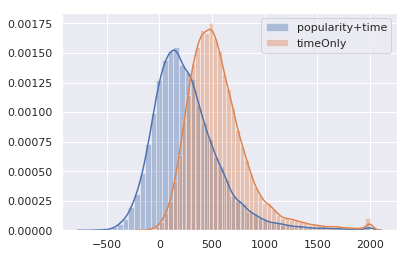

In [40]:
sns.distplot((finalAnswer["answer1"]-finalAnswer["popularity+time"]).clip(upper=2000),label="popularity+time")
sns.distplot((finalAnswer["answer1"]-finalAnswer["timeOnly"]).clip(upper=2000),label="timeOnly")
plt.legend()

In [41]:
from sklearn.metrics import mean_squared_error,mean_absolute_error

In [42]:
np.sqrt(mean_squared_error(finalAnswer["answer1"],finalAnswer["popularity+time"])),mean_absolute_error(finalAnswer["answer1"],finalAnswer["popularity+time"])

(429.2674948124563, 303.71349956837383)

In [43]:
np.sqrt(mean_squared_error(finalAnswer["answer1"],finalAnswer["timeOnly"])),mean_absolute_error(finalAnswer["answer1"],finalAnswer["timeOnly"])

(645.5583667488872, 559.8789238830065)

In [189]:
np.sqrt(mean_squared_error(y_test,regr.predict(X_test))),mean_absolute_error(y_test,regr.predict(X_test))

(217.07917789375784, 147.5974346052176)

In [255]:
np.sqrt(mean_squared_error(y_test2,regr.predict(X_test2))),mean_absolute_error(y_test2,regr.predict(X_test2))

(208.62198322946654, 146.47348012932315)

Text(0, 0.5, 'Actual ETA')

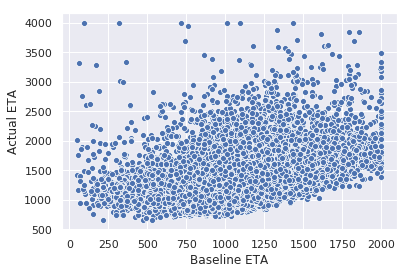

In [992]:
sns.scatterplot(finalAnswer["popularity+time"].clip(upper=2000),finalAnswer["answer1"].clip(upper=4000))
plt.xlabel("Baseline ETA")
plt.ylabel("Actual ETA")

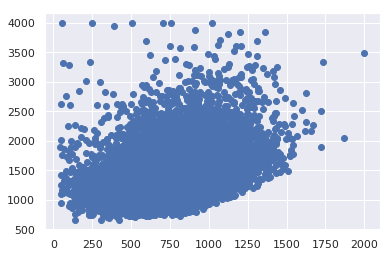

In [46]:
plt.scatter(finalAnswer["timeOnly"].clip(upper=2000),finalAnswer["answer1"].clip(upper=4000))

In [1007]:
h,a=nx.hits(G, max_iter=10000)

In [1008]:
a

{184: 2.7128348036203212e-39,
 185: 2.152102674070136e-39,
 186: 3.89473236155213e-41,
 253: 1.4775034234706371e-37,
 254: 2.1212056068436527e-39,
 323: 1.8349559312943582e-37,
 324: 2.712275649035861e-39,
 249: 1.4762784695695116e-32,
 319: 3.1843102219324455e-32,
 318: 9.823948954662485e-31,
 388: 9.963514964704552e-33,
 320: 4.864351502581089e-34,
 321: 6.756727865303728e-34,
 390: 3.7789049628342244e-34,
 252: 9.843870143313471e-36,
 322: 1.2592271569926156e-35,
 393: 0.0,
 316: 7.836210594865058e-32,
 385: 5.3782856722195296e-30,
 386: 6.743052413380508e-29,
 455: 1.255115637724517e-28,
 456: 1.4022709813020127e-28,
 317: 7.994428776659236e-32,
 389: 3.045286703368661e-32,
 461: 0.0,
 383: 2.450823151335804e-28,
 453: 1.2083831173891383e-26,
 454: 4.046556042738414e-27,
 522: 1.3597615546801088e-25,
 523: 1.5853531634266274e-26,
 384: 3.1609452009461616e-28,
 457: 6.83656735966613e-31,
 525: 4.154748401425883e-29,
 526: 7.114603243216121e-29,
 458: 2.0434279539191413e-30,
 452: 3.

In [48]:
inCentrality=nx.in_degree_centrality(G)

In [49]:
outCentrality=nx.out_degree_centrality(G)

In [50]:
loadCentrality=nx.load_centrality(G,normalized =True,weight ="popularity+time")

In [1009]:
joblib.dump(h,"h.pkl")
joblib.dump(a,"a.pkl")
joblib.dump(inCentrality,"inCentrality.pkl")
joblib.dump(outCentrality,"outCentrality.pkl")
joblib.dump(loadCentrality,"loadCentrality.pkl")
# joblib.dump(h,"h.pkl")

['loadCentrality.pkl']

In [51]:
from functools import reduce

In [52]:
def featureEngineering(df):
    df["dayOfWeek"]=df["Date_min"].dt.dayofweek
    df["Day"]=df["Date_min"].dt.day
    df["month"]=df["Date_min"].dt.month
    df["hour"]=df.Date_min.dt.hour

    df["pathHIndex"]=df['popularity+time_path'].apply(lambda x:sum(map(lambda item:h[item],x)))
    df["pathaIndex"]=df['popularity+time_path'].apply(lambda x:sum(map(lambda item:a[item],x)))
    df["pathInDegreeIndex"]=df['popularity+time_path'].apply(lambda x:sum(map(lambda item:inCentrality[item],x)))
    df["pathOutDegreeIndex"]=df['popularity+time_path'].apply(lambda x:sum(map(lambda item:outCentrality[item],x)))
    df["CountOfGrid"]=df['popularity+time_path'].apply(len)
    df["destLoad"]=df.destination_id.map(loadCentrality)
    df["destHIndex"]=df.destination_id.map(h)
    df["pickUpLoad"]=df.pickup_id.map(loadCentrality)
    df["flowType"]=df.picku_Region +"->"+df.destination_Region
    return df

In [1006]:
a

0         32.190317
1        -14.081167
2         36.558228
3        388.077177
4        -36.898127
            ...    
27995    350.120243
27996    513.222835
27997    -65.032755
27998   -404.156073
27999    -38.382627
Name: error, Length: 28000, dtype: float64

In [53]:
finalAnswer=featureEngineering(finalAnswer)

In [1005]:
finalAnswer[finalAnswer.trj_id ==10][['pathaIndex']]

,pathaIndex
0,0.001943


In [1001]:
finalAnswer

,pathaIndex
0,1.942998e-03
1,1.137513e-01
2,1.933955e-03
3,1.329603e-02
4,1.275300e-02
...,...
27995,6.390491e-10
27996,1.604468e-01
27997,1.133486e-02
27998,4.450350e-10


/root/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1706: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


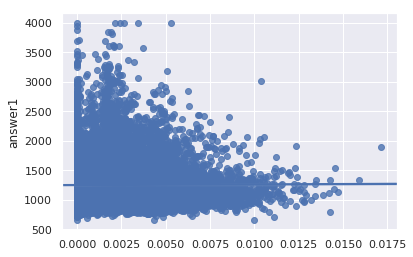

In [54]:
sns.regplot(finalAnswer["pathHIndex"]/finalAnswer["CountOfGrid"],finalAnswer["answer1"].clip(upper=4000))
# plt.xlim(-0.001,0.015)

In [55]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from category_encoders.cat_boost import CatBoostEncoder

In [56]:
finalAnswer["Residual"]=finalAnswer['answer1']-finalAnswer['popularity+time']

In [57]:
finalAnswer["Festival"]=finalAnswer.Day.between(18,21).astype(int)

In [58]:
finalAnswer.month.unique()

array([4])

In [ ]:
finalAnswer

In [250]:
X_train, X_test, y_train, y_test =train_test_split(finalAnswer[['popularity+time',"timeOnly",'dayOfWeek', 'Festival',
       'hour', 'pathHIndex', 'pathaIndex', 'pathInDegreeIndex',
       'pathOutDegreeIndex', 'destLoad', 'pickUpLoad', 'flowType',
       'destHIndex', 'CountOfGrid']],finalAnswer['answer1'],test_size=0.3,random_state=10)

In [182]:
catEncoder=CatBoostEncoder()
X_train["flowType"]=catEncoder.fit_transform(X_train["flowType"],y_train)

X_test["flowType"]=catEncoder.transform(X_test["flowType"])

In [184]:
X_test["flowType"].unique()

array([1593.13583758, 1256.00797055, 1210.52213362, 1207.46358893,
       1180.89557869, 1303.0594967 , 1300.82300547, 1359.1859514 ,
       1212.60945044, 1183.62044368, 1236.68052814, 1152.8923559 ,
       1231.07667026, 1157.51192039, 1217.8147135 , 1365.82557951,
       1415.28189009, 1218.29214931, 1142.47985877, 1120.5827315 ,
       1228.77632366, 1609.20401858, 1197.82738359, 1180.1979932 ,
       1152.8382282 ])

(0, 2000)

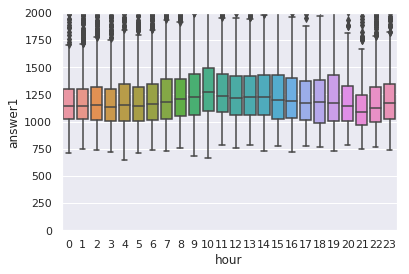

In [185]:
sns.boxplot(finalAnswer.hour,finalAnswer['answer1'])
plt.ylim(0,2000)

(0, 3000)

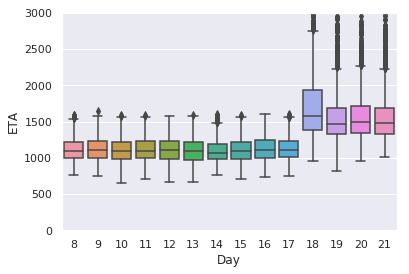

In [987]:
sns.boxplot(finalAnswer.Day,finalAnswer['answer1'])
plt.ylabel("ETA")
plt.ylim(0,3000)

In [187]:
regr = RandomForestRegressor(n_estimators=100,random_state=0, n_jobs=3,min_samples_leaf=20)
regr.fit(X_train, y_train)

RandomForestRegressor(min_samples_leaf=20, n_jobs=3, random_state=0)

In [188]:
regr.score(X_train, y_train),regr.score(X_test, y_test)

(0.6128030653374652, 0.5847709890991513)

/root/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1706: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval
/root/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1706: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


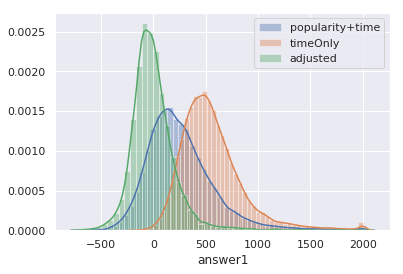

In [67]:
sns.distplot((finalAnswer["answer1"]-finalAnswer["popularity+time"]).clip(upper=2000),label="popularity+time")
sns.distplot((finalAnswer["answer1"]-finalAnswer["timeOnly"]).clip(upper=2000),label="timeOnly")
sns.distplot((y_test-regr.predict(X_test)).clip(upper=2000),label="adjusted")
plt.legend()

In [201]:
finalAnswer.to_csv("TrainingData.csv",index=False)

In [68]:
from sklearn.model_selection import permutation_test_score
from sklearn.metrics import fbeta_score, make_scorer

In [69]:
# score, permutation_scores, pvalue = permutation_test_score(
#     RandomForestRegressor(n_estimators=100,max_depth=10,random_state=0), X_train, y_train, scoring=make_scorer(mean_squared_error), cv=2, n_permutations=10, n_jobs=3)

In [70]:
# print("Regression score %s (pvalue : %s)" % (np.sqrt(score), pvalue))
# plt.hist(np.sqrt(permutation_scores), 20, label='Permutation scores',
#          edgecolor='black')

In [71]:
((y_test-regr.predict(X_test)).apply(abs)<=180).sum()/8400

0.7161904761904762

In [203]:
finalAnswer

,picku_Region,pickup_id,trj_id,destination_Region,destination_id,pingtimestamp_min,pingtimestamp_max,Date_min,Date_max,answer1,...,pathaIndex,pathInDegreeIndex,pathOutDegreeIndex,CountOfGrid,destLoad,destHIndex,pickUpLoad,flowType,Residual,Festival
0,CENTRAL REGION,3467,10,CENTRAL REGION,4295,1554809147,1554810296,2019-04-09 11:25:47,2019-04-09 11:44:56,1149,...,0.001943,0.069985,0.069000,23,0.000035,4.019506e-04,0.001097,CENTRAL REGION->CENTRAL REGION,502.650609,0
1,EAST REGION,5978,100,CENTRAL REGION,4230,1555382655,1555383648,2019-04-16 02:44:15,2019-04-16 03:00:48,993,...,0.154770,0.123706,0.114342,29,0.000000,1.156669e-03,0.001602,EAST REGION->CENTRAL REGION,335.932649,0
2,NORTH REGION,3228,1000,NORTH-EAST REGION,4573,1554943773,1554944629,2019-04-11 00:49:33,2019-04-11 01:03:49,856,...,0.001960,0.117299,0.119271,36,0.137129,4.896368e-04,0.010920,NORTH REGION->NORTH-EAST REGION,91.454433,0
3,NORTH-EAST REGION,4082,10001,WEST REGION,2552,1555502175,1555503425,2019-04-17 11:56:15,2019-04-17 12:17:05,1250,...,0.000595,0.106949,0.106456,35,0.000932,3.472627e-10,0.000009,NORTH-EAST REGION->WEST REGION,403.351302,0
4,NORTH REGION,2878,10004,NORTH-EAST REGION,5407,1554779556,1554780407,2019-04-09 03:12:36,2019-04-09 03:26:47,851,...,0.000031,0.146378,0.149828,46,0.091862,7.934150e-08,0.008487,NORTH REGION->NORTH-EAST REGION,-48.833400,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27995,CENTRAL REGION,4374,997,EAST REGION,6112,1555054579,1555055811,2019-04-12 07:36:19,2019-04-12 07:56:51,1232,...,0.197330,0.208477,0.206506,46,0.002294,7.145551e-09,0.093238,CENTRAL REGION->EAST REGION,216.089224,0
27996,NORTH REGION,3298,9970,CENTRAL REGION,4795,1555579539,1555581297,2019-04-18 09:25:39,2019-04-18 09:54:57,1758,...,0.155484,0.204041,0.199606,54,0.010790,2.715551e-03,0.000685,NORTH REGION->CENTRAL REGION,545.583143,1
27997,WEST REGION,1640,998,CENTRAL REGION,4449,1555626633,1555627861,2019-04-18 22:30:33,2019-04-18 22:51:01,1228,...,0.073650,0.197634,0.196649,54,0.001179,3.538251e-03,0.004137,WEST REGION->CENTRAL REGION,-157.846377,1
27998,CENTRAL REGION,4311,9982,NORTH REGION,3230,1554826935,1554828066,2019-04-09 16:22:15,2019-04-09 16:41:06,1131,...,0.082288,0.174470,0.179892,54,0.099762,1.903408e-12,0.012890,CENTRAL REGION->NORTH REGION,-51.547139,0


In [208]:
hexagon["X"]=hexagon.geometry.centroid.x

In [209]:
hexagon["y"]=hexagon.geometry.centroid.y

In [213]:
hexagon[["id","X","y"]]

,id,X,y
0,2554,103.748091,1.319292
1,2549,103.748090,1.341902
2,2556,103.748091,1.310249
3,2551,103.748091,1.332858
4,2550,103.748090,1.337380
...,...,...,...
4074,2484,103.744200,1.317031
4075,2483,103.744200,1.321553
4076,2553,103.748091,1.323814
4077,2552,103.748091,1.328336


In [223]:
finalAnswer=finalAnswer.merge(hexagon[["id","X","y"]],left_on="pickup_id",right_on="id").merge(hexagon[["id","X","y"]],left_on="destination_id",right_on="id",suffixes=("_pickup","_dest"))

In [226]:
joinedSGGeo=joinedSGGeo.sort_values(by=["trj_id","Date"])

In [234]:
A=joinedSGGeo.drop_duplicates(["trj_id"],keep="first")[["trj_id","rawlat","rawlng"]]

In [235]:
B=joinedSGGeo.drop_duplicates(["trj_id"],keep="last")[["trj_id","rawlat","rawlng"]]

In [237]:
geoInformation=A.merge(B,on="trj_id",suffixes=("_pickup","_dest"))

In [244]:
geoInformation.trj_id=geoInformation.trj_id.astype(int)

In [246]:
finalAnswer=finalAnswer.merge(geoInformation,on="trj_id")

In [335]:
X_train2, X_test2, y_train2, y_test2 =train_test_split(finalAnswer[['popularity+time','dayOfWeek', 'Festival',
       'hour', 'pathHIndex', 'pathaIndex', 'pathInDegreeIndex',
       'pathOutDegreeIndex', 'destLoad', 'pickUpLoad', 'flowType',
       'destHIndex', 'CountOfGrid','rawlat_pickup',
       'rawlng_pickup', 'rawlat_dest', 'rawlng_dest']],finalAnswer['answer1'],test_size=0.3,random_state=10)

In [336]:
X_train2["flowType"]=catEncoder.transform(X_train2["flowType"])

X_test2["flowType"]=catEncoder.transform(X_test2["flowType"])

regr = RandomForestRegressor(n_estimators=100,random_state=0, n_jobs=3,min_samples_leaf=30)
regr.fit(X_train2, y_train2)

regr.score(X_train2, y_train2),regr.score(X_test2, y_test2)

In [270]:
from sklearn.tree import DecisionTreeRegressor
from skopt import gp_minimize
from skopt.space import Real, Integer
from skopt.utils import use_named_args

In [269]:
reg2 = RandomForestRegressor(random_state=0)

space  = [Integer(1, 15, name='max_depth'),
          Integer(10, 100, name="n_estimators"),
          Integer(2, 100, name='min_samples_split'),
          Integer(1, 100, name='min_samples_leaf')]

@use_named_args(space)
def objective(**params):
    reg2.set_params(**params)
    return -np.mean(cross_val_score(reg2, X_train2, y_train2, cv=2, n_jobs=-1, scoring="neg_mean_absolute_error"))

In [284]:
res_gp = gp_minimize(objective, space, n_calls=50, random_state=0)

/root/anaconda3/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:409: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/root/anaconda3/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:409: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/root/anaconda3/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:409: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/root/anaconda3/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:409: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/root/anaconda3/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:409: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/root/anac

In [285]:
print("""Best parameters:- max_depth=%d- n_estimators=%.6f- min_samples_split=%d- min_samples_leaf=%d- """ % (res_gp.x[0], res_gp.x[1], 
                            res_gp.x[2], res_gp.x[3]))

Best parameters:- max_depth=13- n_estimators=77.000000- min_samples_split=2- min_samples_leaf=1- 


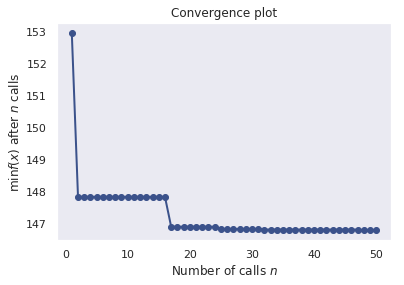

In [286]:
from skopt.plots import plot_convergence

plot_convergence(res_gp)

In [328]:
reg2 = RandomForestRegressor(max_depth=13, min_samples_split=2, n_estimators=77,min_samples_leaf=1,random_state=0)

In [338]:
reg2.fit(X_train2, y_train2)

RandomForestRegressor(max_depth=13, n_estimators=77, random_state=0)

In [339]:
reg2.score(X_train2, y_train2),reg2.score(X_test2, y_test2)

(0.8104712487588721, 0.5936658881004215)

In [340]:
np.sqrt(mean_squared_error(y_test2,reg2.predict(X_test2))),mean_absolute_error(y_test2,reg2.predict(X_test2))

(209.88031184927667, 147.04771658838462)

In [341]:
from sklearn.inspection import permutation_importance
r = permutation_importance(reg2, X_test2, y_test2, n_repeats=30,random_state=0)

In [342]:
for i in r.importances_mean.argsort()[::-1]:
    print(f"{X_train2.columns[i]:<20}"
              f"{r.importances_mean[i]:.6f}"
              f" +/- {r.importances_std[i]:.6f}")

Festival            0.681981 +/- 0.016445
destHIndex          0.435704 +/- 0.099934
popularity+time     0.221828 +/- 0.008993
hour                0.147757 +/- 0.008096
dayOfWeek           0.110507 +/- 0.006805
CountOfGrid         0.075219 +/- 0.005408
rawlat_dest         0.032499 +/- 0.010548
pathOutDegreeIndex  0.022860 +/- 0.001307
rawlng_dest         0.016981 +/- 0.007669
pathInDegreeIndex   0.008953 +/- 0.001032
rawlat_pickup       0.008423 +/- 0.000956
rawlng_pickup       0.005949 +/- 0.001310
pathHIndex          0.005364 +/- 0.001344
destLoad            0.004763 +/- 0.001216
pickUpLoad          0.003672 +/- 0.001745
pathaIndex          0.002195 +/- 0.001146
flowType            0.000398 +/- 0.000534


In [351]:
def haversine(lon1, lat1, lon2, lat2):
    """
    Calculate the great circle distance between two points 
    on the earth (specified in decimal degrees)
    """
    # haversine formula 
    dlon = lon2 - lon1 
    dlat = lat2 - lat1 
    a = np.sin(dlat/2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2)**2
    c = 2 * np.arcsin(np.sqrt(a)) 
    r = 6371 # Radius of earth in kilometers. Use 3956 for miles
    return c * r

In [385]:
def euclidean_distance(x,y):
 
    return np.sqrt((np.sum(np.power(x-y,2),axis=1)))

In [391]:
def manhattan_distance(x,y):
 
    return np.sum(np.abs(x-y),axis=1)

In [352]:
finalAnswer["rawlng_pickup2"] = finalAnswer["rawlng_pickup"].apply(radians)
finalAnswer["rawlat_pickup2"] = finalAnswer["rawlat_pickup"].apply(radians)
finalAnswer["rawlng_dest2"] = finalAnswer["rawlng_dest"].apply(radians)
finalAnswer["rawlat_dest2"] = finalAnswer["rawlat_dest"].apply(radians)

In [354]:
finalAnswer["HarvsineDistance"]=haversine(finalAnswer["rawlng_pickup2"], finalAnswer["rawlat_pickup2"], finalAnswer["rawlng_dest2"], finalAnswer["rawlat_dest2"])

/root/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1706: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


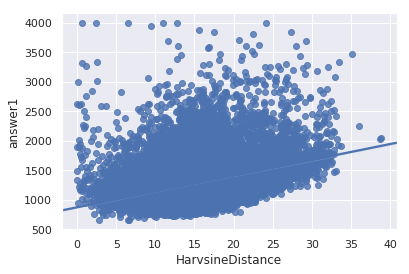

In [362]:
sns.regplot(finalAnswer["HarvsineDistance"],finalAnswer["answer1"].clip(upper=4000))

In [389]:
from scipy.spatial.distance import cdist

finalAnswer["EuclideanDistance"]=euclidean_distance(finalAnswer[["rawlng_pickup","rawlat_pickup"]].values, finalAnswer[["rawlng_dest","rawlat_dest"]].values)

/root/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1706: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


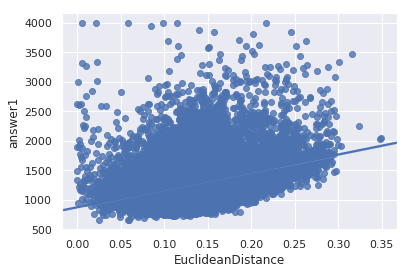

In [390]:
sns.regplot(finalAnswer["EuclideanDistance"],finalAnswer["answer1"].clip(upper=4000))

In [394]:
finalAnswer["ManhattanDistance"]=manhattan_distance(finalAnswer[["rawlng_pickup","rawlat_pickup"]].values, finalAnswer[["rawlng_dest","rawlat_dest"]].values)

/root/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1706: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


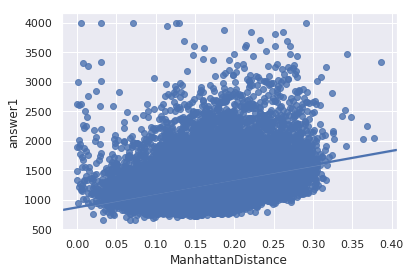

In [395]:
sns.regplot(finalAnswer["ManhattanDistance"],finalAnswer["answer1"].clip(upper=4000))

In [397]:
finalAnswer[[ 'HarvsineDistance','answer1',
       'EuclideanDistance', 'ManhattanDistance']].corr()

,HarvsineDistance,answer1,EuclideanDistance,ManhattanDistance
HarvsineDistance,1.000000,0.365087,1.000000,0.944335
answer1,0.365087,1.000000,0.365065,0.345979
EuclideanDistance,1.000000,0.365065,1.000000,0.944314
ManhattanDistance,0.944335,0.345979,0.944314,1.000000


In [602]:
def classify(x):
    if x >=8 and x<=9:
        return 10
    elif x>=17 and x<=19:
        return 50
    return 100

In [603]:
finalAnswer["TimeInterval"]=finalAnswer.hour.apply(classify)

In [604]:
finalAnswer["TimeInterval"]

0        100
1        100
2        100
3        100
4        100
        ... 
27995    100
27996    100
27997    100
27998     10
27999    100
Name: TimeInterval, Length: 28000, dtype: int64

In [640]:
finalAnswer["PopularPlace"]=0

In [869]:
finalAnswer["Weekend"]=finalAnswer.dayOfWeek.map({6:1,5:1}).fillna(0)

In [641]:
finalAnswer.loc[finalAnswer.destination_id.isin([6815,6816,6885,6886,517,587,588,658,659,590,519,589,2877,2876,2875,2947,2946,2945]),'PopularPlace']=1

In [928]:
X_train2, X_test2, y_train2, y_test2 =train_test_split(finalAnswer[['popularity+time',"PopularPlace","TimeInterval",'dayOfWeek', 'Festival',
       'hour', 'pathHIndex', 'pathaIndex', 'pathInDegreeIndex',
       'pathOutDegreeIndex', 'destLoad', 'pickUpLoad', 'flowType',
       'destHIndex', 'CountOfGrid','rawlat_pickup',
       'rawlng_pickup', 'rawlat_dest', 'rawlng_dest',"HarvsineDistance","Weekend"]],finalAnswer['answer1'],test_size=0.3,random_state=10)

In [929]:
X_train2["flowType"]=catEncoder.fit_transform(X_train2["flowType"],y_train2)
X_test2["flowType"]=catEncoder.transform(X_test2["flowType"])

In [913]:
X_test2["TimeInterval"].unique()

array([100,  10,  50])

In [914]:
reg3 = RandomForestRegressor(max_depth=15, min_samples_split=2, n_estimators=85,min_samples_leaf=10,random_state=0)

In [915]:
reg3.fit(X_train2, y_train2)

RandomForestRegressor(max_depth=15, min_samples_leaf=10, n_estimators=85,
                      random_state=0)

In [916]:
reg3.score(X_train2, y_train2),reg3.score(X_test2, y_test2)

(0.6713878623837549, 0.6072702379617676)

In [917]:
# finalAnswer.loc[X_train2.index,"predicted"]=reg3.predict(X_train2)
# finalAnswer.loc[X_test2.index,"predicted"]=reg3.predict(X_test2)

In [977]:
np.sqrt(mean_squared_error(y_test2,reg3.predict(X_test2))),mean_absolute_error(y_test2,reg3.predict(X_test2))

(206.33693092532803, 145.4456875816256)

In [860]:
# finalAnswer["error"]=finalAnswer["answer1"]-finalAnswer["predicted"]

# a = finalAnswer["error"].clip(upper=2500)
# counts, bins = np.histogram(a, bins=500, density=True)
# cum_counts = np.cumsum(counts)
# bin_widths = (bins[1:] - bins[:-1])

# x = cum_counts*bin_widths
# y = bins[1:]
# inverse_density_function = scipy.interpolate.interp1d(x, y)



# from scipy.stats import distributions
# import scipy
# from scipy.stats import t
# mean, var  = distributions.norm.fit(finalAnswer[finalAnswer["Festival"]==1].error.clip(upper=2500))

# testDist=finalAnswer.iloc[X_train2.index]
# param = t.fit(testDist[testDist["Festival"]==1].error.clip(upper=2500))

# finalAnswer["error2"]=finalAnswer["error"]

# finalAnswer.loc[finalAnswer["Festival"]==1,"error2"]=pd.Series(t.rvs(param[0],param[1],param[2],size=8010)).clip(-2500,2500).values

# finalAnswer["predicted2"]=finalAnswer["predicted"]

# finalAnswer.loc[finalAnswer["Festival"]==1,"predicted2"]=\
# finalAnswer.loc[finalAnswer["Festival"]==1,"error2"]+finalAnswer.loc[finalAnswer["Festival"]==1,"predicted"]

# np.sqrt(mean_squared_error(finalAnswer.iloc[X_test.index]["answer1"],finalAnswer.iloc[X_test.index]["predicted2"]))

# finalAnswer[finalAnswer["Festival"]==1][["answer1","predicted","predicted2"]]

# s = np.random.normal(mean, var, 1000)

# # sns.distplot(finalAnswer[finalAnswer["Festival"]==1].error.clip(lower=-2500,upper=2500))
# sns.distplot(s)
# sns.distplot(inverse_density_function(np.random.uniform( x[0], x[-1],size=1000)))
# sns.distplot(finalAnswer.iloc[X_test.index]["error"])
# sns.distplot(finalAnswer.iloc[X_train.index]["error"].clip(lower=-2500,upper=2500))



In [612]:
res_gp = gp_minimize(objective, space, n_calls=50, random_state=0)

/root/anaconda3/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:409: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/root/anaconda3/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:409: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/root/anaconda3/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:409: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


In [613]:
print("""Best parameters:- max_depth=%d- n_estimators=%.6f- min_samples_split=%d- min_samples_leaf=%d- """ % (res_gp.x[0], res_gp.x[1], 
                            res_gp.x[2], res_gp.x[3]))

Best parameters:- max_depth=15- n_estimators=85.000000- min_samples_split=2- min_samples_leaf=10- 


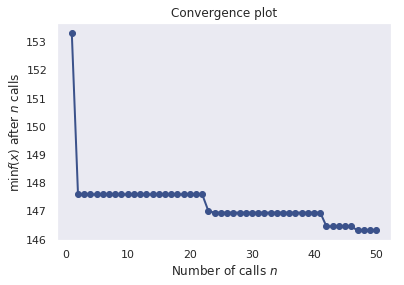

In [614]:
from skopt.plots import plot_convergence

plot_convergence(res_gp)

In [619]:
from sklearn.inspection import permutation_importance
r = permutation_importance(reg3, X_test2, y_test2, n_repeats=30,random_state=0)

In [620]:
for i in r.importances_mean.argsort()[::-1]:
    print(f"{X_train2.columns[i]:<20}"
              f"{r.importances_mean[i]:.6f}"
              f" +/- {r.importances_std[i]:.6f}")

Festival            0.660539 +/- 0.013713
popularity+time     0.187613 +/- 0.005692
hour                0.148449 +/- 0.007002
dayOfWeek           0.116223 +/- 0.006912
HarvsineDistance    0.019618 +/- 0.002605
CountOfGrid         0.007328 +/- 0.001728
rawlat_pickup       0.007113 +/- 0.000777
rawlat_dest         0.007049 +/- 0.000805
rawlng_pickup       0.006642 +/- 0.001287
destLoad            0.005178 +/- 0.001070
rawlng_dest         0.005097 +/- 0.000855
pathHIndex          0.003624 +/- 0.000920
pathOutDegreeIndex  0.003448 +/- 0.000366
pickUpLoad          0.003071 +/- 0.001044
pathInDegreeIndex   0.002221 +/- 0.000325
flowType            0.001761 +/- 0.000434
pathaIndex          0.001691 +/- 0.000556
destHIndex          0.001442 +/- 0.000398
TimeInterval        0.000373 +/- 0.000167


In [930]:
from xgboost import XGBRegressor

model=XGBRegressor(random_state=0)
model.fit(X_train2, y_train2)

In [979]:
np.sqrt(mean_squared_error(y_test2,model.predict(X_test2))),mean_absolute_error(y_test2,model.predict(X_test2))

(209.80012077014672, 143.72398842947823)

In [ ]:
from skopt.space import 

In [970]:
bds = [Real(0.01, 1.0, 'log-uniform', name='learning_rate'),
       Real(0.01, 5, name='gamma'),
       Integer(1, 50, name="max_depth"),
       Integer(2, 300, name='n_estimators'),
        Integer(1, 10, name='min_child_weight')]

In [971]:
@use_named_args(bds)
def objective2(**params):
    model.set_params(**params)
    return -np.mean(cross_val_score(model, X_train2, y_train2, cv=2, n_jobs=-1, scoring="neg_mean_absolute_error"))

In [972]:
res_gp = gp_minimize(objective2, bds, n_calls=25, random_state=0)

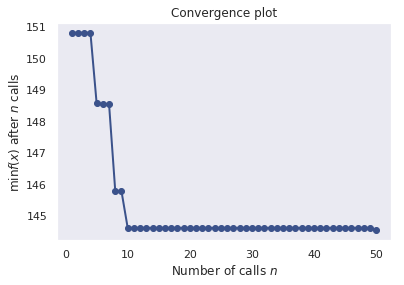

In [973]:
plot_convergence(res_gp)

In [975]:
model=XGBRegressor(learning_rate=res_gp.x[0],gamma=res_gp.x[1],max_depth=res_gp.x[2],n_estimators=res_gp.x[3],min_child_weight=res_gp.x[4],random_state=0)
model.fit(X_train2, y_train2)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0.01, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.08673086171305135, max_delta_step=0, max_depth=50,
             min_child_weight=10, missing=nan, monotone_constraints='()',
             n_estimators=47, n_jobs=0, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

In [980]:
model.score(X_train2, y_train2),model.score(X_test2, y_test2)

(0.8888617549832514, 0.5939763330937087)

In [650]:
investigation=(y_test2-reg3.predict(X_test2)).reset_index()

In [651]:
investigation["actual"]=y_test2.values

In [652]:
investigation["predicted"]=reg3.predict(X_test2)

In [653]:
investigation["error"]=investigation.answer1.apply(abs)

In [654]:
exclude=investigation.sort_values("error",ascending=False).head(50)["index"]

In [655]:
excludedDF=investigation[~investigation["index"].isin(exclude)]

In [656]:
np.sqrt(mean_squared_error(excludedDF.actual,excludedDF.predicted))

184.60130743502077

(0, 1000)

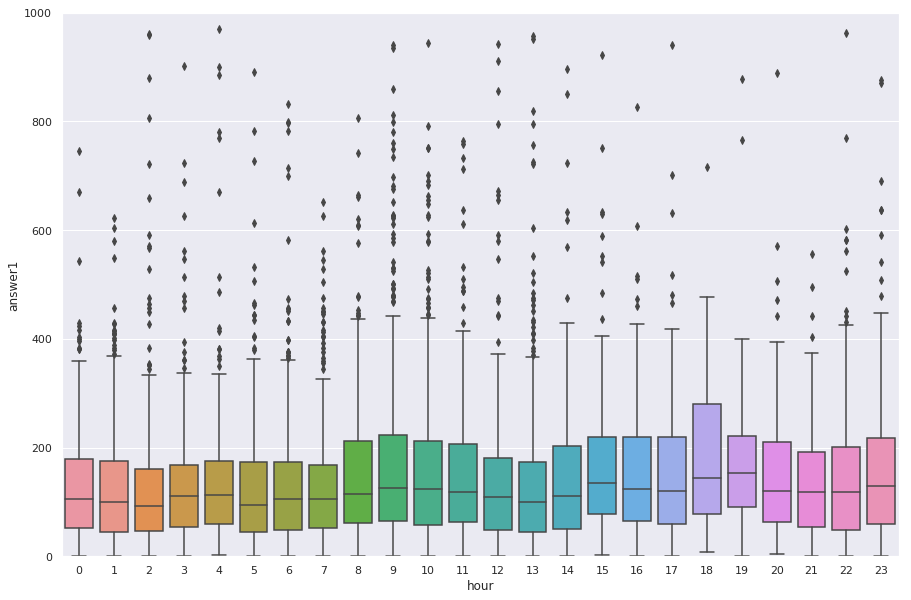

In [657]:
plt.figure(figsize=(15,10))
sns.boxplot(X_test2.hour,(y_test2-reg3.predict(X_test2)).apply(abs))
plt.ylim(0,1000)

(0, 1000)

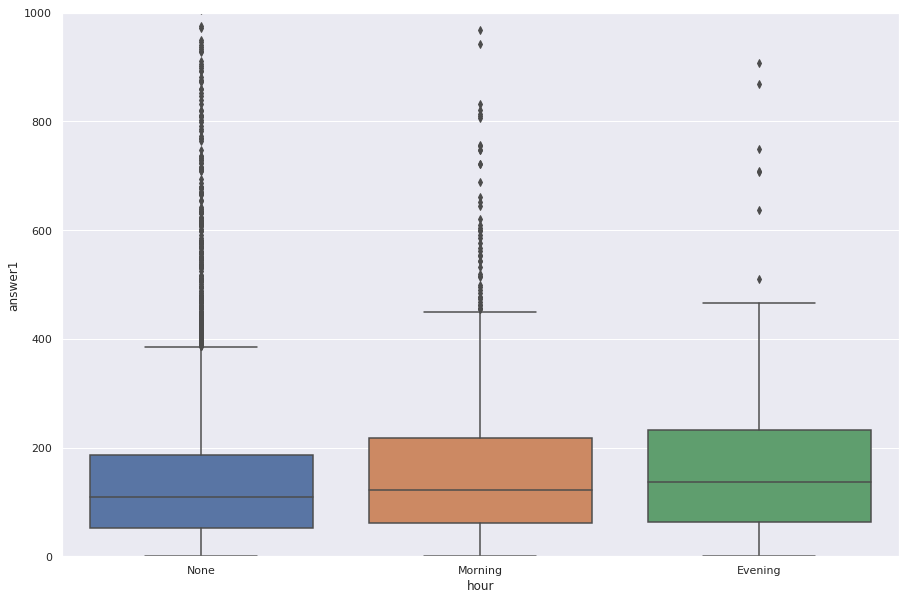

In [517]:
plt.figure(figsize=(15,10))
sns.boxplot(X_test2.hour.apply(classify),(y_test2-reg3.predict(X_test2)).apply(abs))
plt.ylim(0,1000)

In [481]:
investigation[investigation["index"].isin(exclude)]#[investigation.index == 673]

,index,answer1,actual,predicted,error
36,13292,907.448095,2351,1443.551905,907.448095
220,17685,1169.434669,2682,1512.565331,1169.434669
225,25208,1175.698210,2697,1521.301790,1175.698210
355,26312,1496.404707,3475,1978.595293,1496.404707
377,2028,1081.676307,3610,2528.323693,1081.676307
395,3106,939.690691,2278,1338.309309,939.690691
448,17590,937.284596,2451,1513.715404,937.284596
575,13582,1153.482869,2755,1601.517131,1153.482869
585,673,1205.341230,2675,1469.658770,1205.341230
886,23560,1775.795839,3452,1676.204161,1775.795839


In [658]:
investigation

,index,answer1,actual,predicted,error
0,5011,-196.970415,815,1011.970415,196.970415
1,16096,-126.209995,1014,1140.209995,126.209995
2,8804,-55.248617,1136,1191.248617,55.248617
3,18525,93.608344,1109,1015.391656,93.608344
4,2120,-253.857160,796,1049.857160,253.857160
...,...,...,...,...,...
8395,3717,39.027328,1150,1110.972672,39.027328
8396,19480,94.624096,1397,1302.375904,94.624096
8397,12216,-712.190432,1851,2563.190432,712.190432
8398,17631,257.009849,2034,1776.990151,257.009849


In [526]:
finalAnswer.iloc[exclude].Day.value_counts()

21    14
18    13
19    12
20    11
Name: Day, dtype: int64

In [528]:
finalAnswer.columns

Index(['picku_Region', 'pickup_id', 'trj_id', 'destination_Region',
       'destination_id', 'pingtimestamp_min', 'pingtimestamp_max', 'Date_min',
       'Date_max', 'answer1', 'answer2', 'popularity+time',
       'popularity+time_path', 'timeOnly', 'timeOnlyPath', 'dayOfWeek', 'Day',
       'month', 'hour', 'pathHIndex', 'pathaIndex', 'pathInDegreeIndex',
       'pathOutDegreeIndex', 'CountOfGrid', 'destLoad', 'destHIndex',
       'pickUpLoad', 'flowType', 'Residual', 'Festival', 'id_pickup',
       'X_pickup', 'y_pickup', 'id_dest', 'X_dest', 'y_dest', 'rawlat_pickup',
       'rawlng_pickup', 'rawlat_dest', 'rawlng_dest', 'rawlng_pickup2',
       'rawlat_pickup2', 'rawlng_dest2', 'rawlat_dest2', 'HarvsineDistance',
       'EuclideanDistance', 'ManhattanDistance'],
      dtype='object')

/root/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1706: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


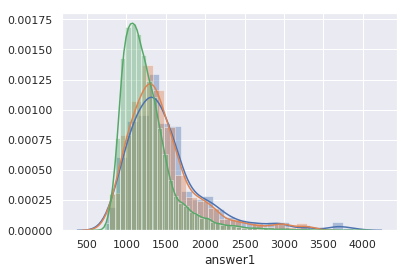

In [577]:
sns.distplot(finalAnswer[finalAnswer.destination_id.isin([6815,6816,6885,6886,517,587,588,658,659,590,519,589,2877,2876,2875,2947,2946,2945])].answer1)
sns.distplot(finalAnswer[finalAnswer.destination_id.isin([6815,6816,6885,6886])].answer1)
sns.distplot(finalAnswer.answer1.clip(upper=4000))

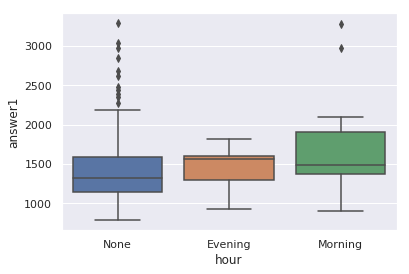

In [576]:
subset=finalAnswer[(finalAnswer.destination_id.isin([6815,6816,6885,6886]))]
sns.boxplot(subset.hour.apply(classify),subset.answer1)

In [547]:
finalAnswer[finalAnswer.destination_id.isin([2877,2876,2875,2947,2946,2945])].dayOfWeek.value_counts()

3    45
6    14
4    11
5     8
1     7
0     7
2     6
Name: dayOfWeek, dtype: int64

In [557]:
finalAnswer[(finalAnswer.destination_id.isin([2877,2876,2875,2947,2946,2945]))].hour.value_counts()

12    15
13    11
7      8
10     8
0      5
21     5
8      5
2      4
9      4
22     4
11     4
15     4
5      3
14     2
17     2
19     2
4      2
3      2
1      2
23     2
16     1
18     1
6      1
20     1
Name: hour, dtype: int64

In [550]:
finalAnswer[(finalAnswer.destination_id.isin([2877,2876,2875,2947,2946,2945]) & (finalAnswer.dayOfWeek==3))].Day.value_counts()

18    42
11     3
Name: Day, dtype: int64

In [551]:
finalAnswer[(finalAnswer.destination_id.isin([2877,2876,2875,2947,2946,2945]) & (finalAnswer.dayOfWeek==3))]

,picku_Region,pickup_id,trj_id,destination_Region,destination_id,pingtimestamp_min,pingtimestamp_max,Date_min,Date_max,answer1,...,rawlng_pickup,rawlat_dest,rawlng_dest,rawlng_pickup2,rawlat_pickup2,rawlng_dest2,rawlat_dest2,HarvsineDistance,EuclideanDistance,ManhattanDistance
8996,WEST REGION,2198,77165,NORTH REGION,2946,1555011376,1555012882,2019-04-11 19:36:16,2019-04-11 20:01:22,1506,...,103.729156,1.444530,103.772033,1.810415,0.023464,1.811164,0.025212,12.109933,0.108912,0.142994
13335,WEST REGION,1569,67319,NORTH REGION,2877,1555592933,1555594104,2019-04-18 13:08:53,2019-04-18 13:28:24,1171,...,103.693410,1.440793,103.768678,1.809791,0.023424,1.811105,0.025147,13.797767,0.124100,0.173936
13339,CENTRAL REGION,4028,78116,NORTH REGION,2877,1555590996,1555593292,2019-04-18 12:36:36,2019-04-18 13:14:52,2296,...,103.830013,1.440626,103.768572,1.812176,0.022668,1.811103,0.025144,17.185026,0.154556,0.203260
13340,CENTRAL REGION,4865,44518,NORTH REGION,2877,1555593544,1555595101,2019-04-18 13:19:04,2019-04-18 13:45:01,1557,...,103.875456,1.440875,103.768651,1.812969,0.022879,1.811105,0.025148,18.706123,0.168248,0.236805
13345,EAST REGION,6467,43335,NORTH REGION,2877,1555593063,1555594664,2019-04-18 13:11:03,2019-04-18 13:37:44,1601,...,103.964557,1.439928,103.768767,1.814524,0.023609,1.811107,0.025131,23.826805,0.214333,0.282995
13350,CENTRAL REGION,4377,31402,NORTH REGION,2877,1555573367,1555575066,2019-04-18 07:42:47,2019-04-18 08:11:06,1699,...,103.849529,1.440781,103.768631,1.812516,0.022790,1.811104,0.025146,17.498002,0.157375,0.215889
13353,CENTRAL REGION,4304,37489,NORTH REGION,2877,1555581717,1555584135,2019-04-18 10:01:57,2019-04-18 10:42:15,2418,...,103.845808,1.440774,103.768587,1.812451,0.023020,1.811103,0.025146,16.037969,0.144245,0.199055
13354,CENTRAL REGION,3956,30075,NORTH REGION,2877,1555582063,1555584799,2019-04-18 10:07:43,2019-04-18 10:53:19,2736,...,103.825150,1.439776,103.769209,1.812091,0.022888,1.811114,0.025129,15.571082,0.140041,0.184323
13356,CENTRAL REGION,4518,78040,NORTH REGION,2877,1555584476,1555587081,2019-04-18 10:47:56,2019-04-18 11:31:21,2605,...,103.855646,1.440064,103.768606,1.812623,0.022704,1.811104,0.025134,18.254188,0.164177,0.226245
13357,WEST REGION,2688,1868,NORTH REGION,2877,1555582343,1555584391,2019-04-18 10:12:23,2019-04-18 10:46:31,2048,...,103.758202,1.440762,103.768625,1.810922,0.023492,1.811104,0.025146,10.602094,0.095347,0.105199
